## 1. Mount Drive and Read Data

In [ ]:
# Mount google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/My Drive/Data/train'
test_dir = '/content/drive/My Drive/Data/test'

In [ ]:
print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_covid19 = len(os.listdir(os.path.join(train_dir, 'COVID19')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")
print(f"COVID19={num_covid19}")


print("Test set:\n========================================")
num_pneumonia_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
num_normal_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
num_covid19_test = len(os.listdir(os.path.join(test_dir, 'COVID19')))
print(f"PNEUMONIA={num_pneumonia_test}")
print(f"NORMAL={num_normal_test}")
print(f"COVID19={num_covid19_test}")

Train set:
PNEUMONIA=3418
NORMAL=1266
COVID19=1349
Test set:
PNEUMONIA=855
NORMAL=317
COVID19=116


In [ ]:
# Compute class weights
weight_for_covid19 = num_covid19 / (num_normal + num_pneumonia + num_covid19)
weight_for_normal = num_normal / (num_normal + num_pneumonia + num_covid19)
weight_for_pneumonia = num_pneumonia / (num_normal + num_pneumonia + num_covid19)

class_weight = {0: weight_for_covid19, 1: weight_for_normal, 2: weight_for_pneumonia}

print(f"Weight for class 0 (Covid19): {weight_for_covid19:.2f}")
print(f"Weight for class 1 (Normal): {weight_for_normal:.2f}")
print(f"Weight for class 2 (Pneumonia): {weight_for_pneumonia:.2f}")

Weight for class 0 (Covid19): 0.22
Weight for class 1 (Normal): 0.21
Weight for class 2 (Pneumonia): 0.57


## 2. Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow

from keras import optimizers
from keras.applications import xception
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from numpy.random import seed

%matplotlib inline

# Set seed
seed(1)
tensorflow.random.set_seed(2)

## 3. Model with Augmentation
- Training Accuracy: 96.04%
- Testing Accuracy: 91.61%
- Note: Model results for that without Augmentation can be found under Hypothesis 2's Notebook
  - Training Accuracy: 100%
  - Testing Accuracy: 96.12%

Image Augmentation

In [ ]:
img_size = 299

In [ ]:
# Image Preprocessing to perform standardization and augmentation
train_image_datagen = ImageDataGenerator(rescale=1./299,
                                         rotation_range=120,
                                         zoom_range=0.2)

train_datagen = train_image_datagen.flow_from_directory(train_dir, 
                                                        batch_size=32, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

test_image_datagen = ImageDataGenerator(rescale=1./299)

test_datagen = test_image_datagen.flow_from_directory(test_dir, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='categorical', 
                                                      target_size=(img_size, img_size))

print(train_datagen.class_indices) # check class indices

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


Model

In [ ]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
189/189 [==============================] - 1720s 9s/step - loss: 0.4818 - accuracy: 0.8344 - val_loss: 0.2182 - val_accuracy: 0.9239

Epoch 00001: val_accuracy improved from -inf to 0.92391, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
189/189 [==============================] - 351s 2s/step - loss: 0.0748 - accuracy: 0.9103 - val_loss: 0.1726 - val_accuracy: 0.9325

Epoch 00002: val_accuracy improved from 0.92391 to 0.93245, saving model to model.h5
Epoch 3/20
189/189 [==============================] - 358s 2s/step - loss: 0.0648 - accuracy: 0.9191 - val_loss: 0.2411 - val_accuracy: 0.9177

Epoch 00003: val_accuracy did not improve from 0.93245
Epoch 4/20
189/189 [==============================] - 342s 2s/step - loss: 0.0596 - accuracy: 0.9239 - val_loss: 0.1433 - val_accuracy: 0.9480

Epoch 00004: val_accuracy improved from 0.93245 to 0.94798, saving model to model.h5
Epoch 5/20
189/189 [==============================] - 347s 2s/step - loss: 0.0496 - accuracy: 0.9350 - val_loss: 0.2061 - val_accuracy: 0.9363

Epoch 00005: val_accuracy did not improve from 0.94798
Epoch 6/20
189/189 [==============================] - 346s 2s/step - loss: 0.0572 - accuracy: 0.9299 - val_loss: 0.1724 - val_accuracy: 0.9433



Model Evaluation

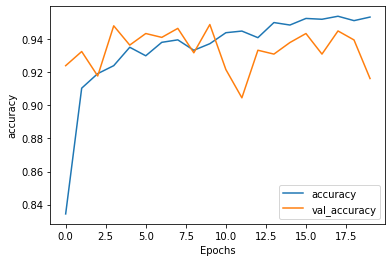

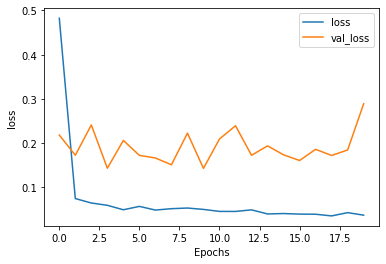

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

81/81 [==============================] - 43s 527ms/step - loss: 0.2887 - accuracy: 0.9161
Test Accuracy: 91.61%
189/189 [==============================] - 299s 2s/step - loss: 0.1147 - accuracy: 0.9604
Train Accuracy: 96.04%


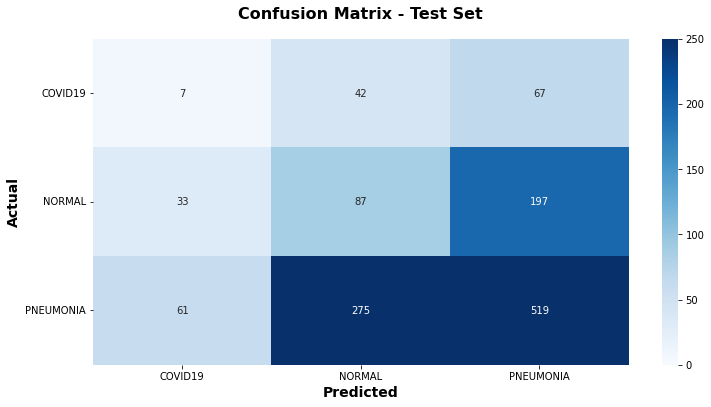

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 4. Model with Augmentation (Variation 1)
- Training Accuracy: 96.20%
- Testing Accuracy: 95.19%
- Note: Model results for that without Augmentation can be found under Hypothesis 2's Notebook
  - Training Accuracy: 100%
  - Testing Accuracy: 96.12%

Image Augmentation

In [ ]:
img_size = 299

In [ ]:
# Image Preprocessing to perform standardization and augmentation
train_image_datagen1 = ImageDataGenerator(rescale=1./299,
                                         rotation_range=120,
                                         zoom_range=0.1,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1)

train_datagen1 = train_image_datagen1.flow_from_directory(train_dir, 
                                                          batch_size=32, 
                                                          shuffle=True, 
                                                          class_mode='categorical', 
                                                          target_size=(img_size, img_size))

test_image_datagen1 = ImageDataGenerator(rescale=1./299)

test_datagen1 = test_image_datagen1.flow_from_directory(test_dir, 
                                                        batch_size=16, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

print(train_datagen1.class_indices) # check class indices

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


Model

In [ ]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model1 = Model(inputs = base_model.input, outputs = output)

model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("model1.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model1.fit(train_datagen1,
                    validation_data = test_datagen1, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/20
189/189 [==============================] - 355s 2s/step - loss: 0.4325 - accuracy: 0.8293 - val_loss: 0.2372 - val_accuracy: 0.9193

Epoch 00001: val_accuracy improved from -inf to 0.91925, saving model to model1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
189/189 [==============================] - 363s 2s/step - loss: 0.0819 - accuracy: 0.9030 - val_loss: 0.5554 - val_accuracy: 0.7601

Epoch 00002: val_accuracy did not improve from 0.91925
Epoch 3/20
189/189 [==============================] - 356s 2s/step - loss: 0.0651 - accuracy: 0.9234 - val_loss: 0.2047 - val_accuracy: 0.9262

Epoch 00003: val_accuracy improved from 0.91925 to 0.92624, saving model to model1.h5
Epoch 4/20
189/189 [==============================] - 361s 2s/step - loss: 0.0640 - accuracy: 0.9224 - val_loss: 0.2720 - val_accuracy: 0.9061

Epoch 00004: val_accuracy did not improve from 0.92624
Epoch 5/20
189/189 [==============================] - 352s 2s/step - loss: 0.0570 - accuracy: 0.9287 - val_loss: 0.1595 - val_accuracy: 0.9464

Epoch 00005: val_accuracy improved from 0.92624 to 0.94643, saving model to model1.h5
Epoch 6/20
189/189 [==============================] - 359s 2s/step - loss: 0.0518 - accuracy: 0.9383 - val_loss: 0.1955 - val_accuracy: 0.9247

Model Evaluation

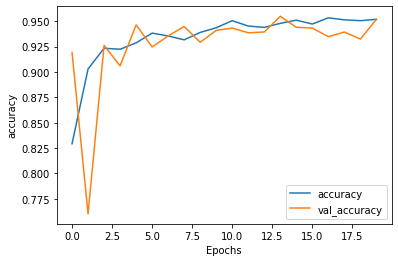

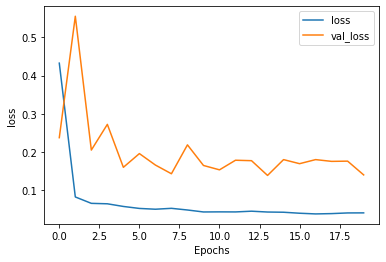

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model1.evaluate(test_datagen1)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model1.evaluate(train_datagen1)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

81/81 [==============================] - 42s 522ms/step - loss: 0.1396 - accuracy: 0.9519
Test Accuracy: 95.19%
189/189 [==============================] - 299s 2s/step - loss: 0.1029 - accuracy: 0.9620
Train Accuracy: 96.20%


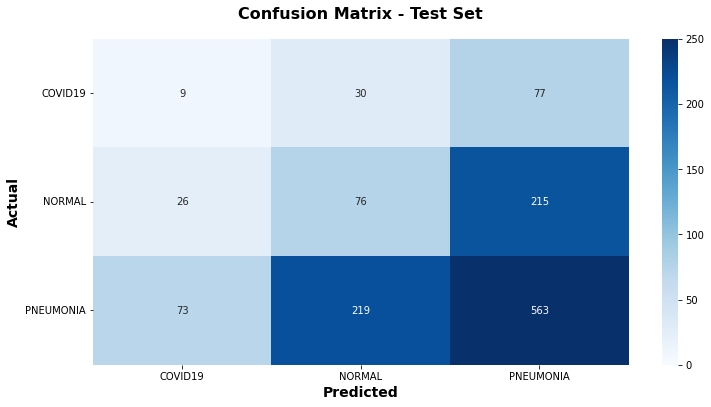

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model1.predict(test_datagen1)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen1.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## 5. Model with Augmentation (Variation 2) - ignore
- Training Accuracy: %
- Testing Accuracy: %
- Note: Model results for that without Augmentation can be found under Hypothesis 2's Notebook
  - Training Accuracy: 100%
  - Testing Accuracy: 96.12%

Image Augmentation

In [ ]:
img_size = 299

In [ ]:
# Image Preprocessing to perform standardization and augmentation
train_image_datagen2 = ImageDataGenerator(horizontal_flip=True,
                                          rotation_range=10,
                                          zoom_range=0.1)

train_datagen2 = train_image_datagen2.flow_from_directory(train_dir, 
                                                          batch_size=32, 
                                                          shuffle=True, 
                                                          class_mode='categorical', 
                                                          target_size=(img_size, img_size))

test_image_datagen2 = ImageDataGenerator(rescale=1./299)

test_datagen2 = test_image_datagen2.flow_from_directory(test_dir, 
                                                        batch_size=16, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

print(train_datagen2.class_indices) # check class indices

Model

In [ ]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model1 = Model(inputs = base_model.input, outputs = output)

model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model1.summary()

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("model2.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model2.fit(train_datagen2,
                    validation_data = test_datagen2, 
                    class_weight = class_weight,
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Model Evaluation

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model1.evaluate(test_datagen2)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model1.evaluate(train_datagen2)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model2.predict(test_datagen2)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen1.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);